# Imports

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import numpy as np

import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Using TensorFlow backend.


# Load Data

In [3]:
data = pd.read_csv("data/data_cleaned.csv")

# Data Preparation

In [4]:
# one hot
data = pd.get_dummies(data, prefix = ["HEAT", "AC", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ASSESSMENT_SUBNBHD"], columns = ["HEAT", "AC", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ASSESSMENT_SUBNBHD"])

In [5]:
# split
x_data = data.drop(["PRICE"], axis=1)
y_data = data["PRICE"]

In [6]:
# normalization
x_data = x_data.astype(float)
x_data = x_data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [7]:
# train & test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

In [8]:
# logarithmen of the price
y_train = np.log(y_train)
y_test = np.log(y_test)

AttributeError: module 'numpy' has no attribute 'ln'

# NN

In [58]:
model = Sequential()
model.add(Dense(256, activation="tanh", kernel_initializer='normal', input_shape=(247,)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu", kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu", kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1(0.02), bias_regularizer=regularizers.l1(0.02)))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1_l2(0.02), bias_regularizer=regularizers.l1_l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu", kernel_initializer='normal'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(
    loss='mean_squared_error',
    optimizer='nadam',
    metrics=["mae"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               63488     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
__________

In [59]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint(filepath='./weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(x_train, 
          y_train,
          batch_size = 128,
          shuffle = True,
          epochs = 200,
          validation_data = (x_test, y_test),
          callbacks=[es, mc])

Train on 40115 samples, validate on 19759 samples
Epoch 1/200
40115/40115 [==============================] - 28s 690us/step - loss: 184.1338 - mean_absolute_error: 3.5157 - val_loss: 57.9149 - val_mean_absolute_error: 2.3737

Epoch 00001: val_loss improved from inf to 57.91487, saving model to ./weights.hdf5
Epoch 2/200
40115/40115 [==============================] - 26s 636us/step - loss: 30.2264 - mean_absolute_error: 2.2370 - val_loss: 5.4711 - val_mean_absolute_error: 0.7252

Epoch 00002: val_loss improved from 57.91487 to 5.47114, saving model to ./weights.hdf5
Epoch 3/200
40115/40115 [==============================] - 25s 615us/step - loss: 7.7207 - mean_absolute_error: 1.6318 - val_loss: 3.9912 - val_mean_absolute_error: 0.6193

Epoch 00003: val_loss improved from 5.47114 to 3.99118, saving model to ./weights.hdf5
Epoch 4/200
40115/40115 [==============================] - 25s 634us/step - loss: 7.4316 - mean_absolute_error: 1.6025 - val_loss: 4.0365 - val_mean_absolute_error: 0.5

In [60]:
model.load_weights('./weights.hdf5')

train_score = model.evaluate(x_train, y_train, verbose=0)
valid_score = model.evaluate(x_test, y_test, verbose=0)

y_pred = model.predict(x_test)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  0.655 , Train Loss:  3.5857
Val MAE:  0.6552 , Val Loss:  3.5851


In [61]:
r2_score(y_test, y_pred)

0.38048056172381239

In [1]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, c='black')
ax.plot([0, y_test.max()], [0, y_test.max()], "k--", lw=4)
plt.show()

NameError: name 'plt' is not defined

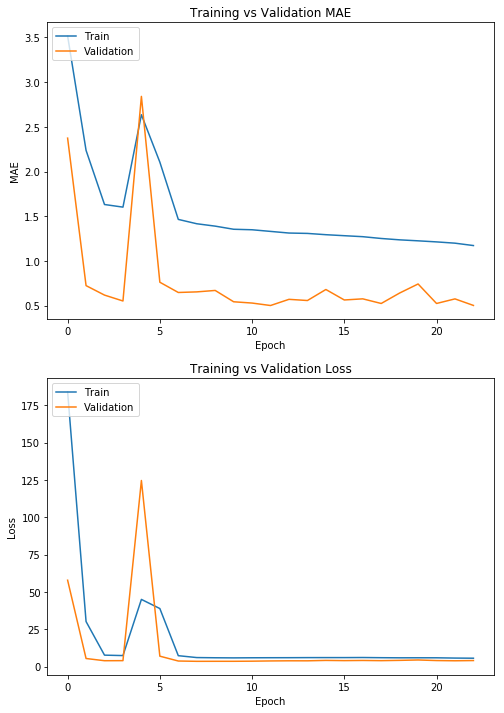

In [63]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

plot_hist(history.history, xsize=8, ysize=12) 